
The goal of this notebook is to guide new users in order to use the repository and generate different types of features.

Below is an overview of different types of data sources used and what type of transformation was used to generate the emebddings.



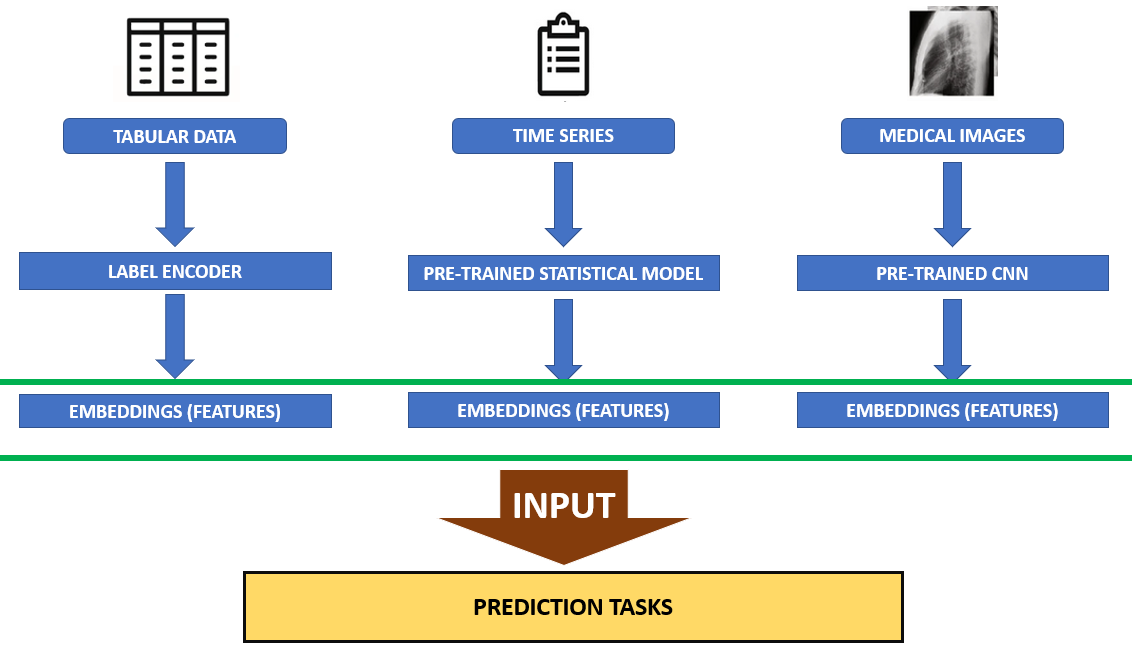



The datasets used to replicate the embeddings generation are publicly available at: physionet (https://physionet.org/content/haim-multimodal/1.0.1/)

Follow the instruction in Readme file to download and copy.

## 0- Introduction

MIMIC-IV is a ```relational database``` containing real hospital stays for patients admitted to a tertiary academic medical center in Boston, MA, USA. 

MIMIC-IV contains comprehensive information for each patient while they were in the hospital: laboratory measurements, medications administered, vital signs documented, and so on. 

MIMIC-IV is separated into ```modules``` to reflect the provenance of the data. There are currently five modules:

    - hosp
    - icu 
    - ed 
    - cxr
    - note 

All patients across all datasets are in the hosp module. However, not all ICU patients have ED data, not all ICU patients have CXRs, not all ED patients have hospital data, and so on. Within an individual dataset, there are also incomplete tables as certain electronic systems did not exist in the past, particularly the eMAR system.

(https://mimic.mit.edu/docs/iv/)

### Patient identifiers


Patients are identified in the database using three possible identifiers: ```subject_id```, ```hadm_id```, and ```stay_id```.

Every ```unique patient``` is assigned a ```unique subject_id```, all ```unique hospitalizations``` are assigned a ```unique hadm_id```, and finally all ```unique ward stays``` are assigned a ```unique transfer_id```. 

In this context, a ```ward``` is a ```distinct area of the hospital```, and a ```new transfer_id``` is assigned to a patient if the hospital patient tracking system records that they have been ```moved from one room to another```.

However, many patients will move from one specific location to another, but practically their type of care has not changed. A good example is a patient moving bed locations within an ICU: these changes result in the patient having a new transfer_id, but the patient never left the ICU and we would consider this as a continuous episode of care. 

In order to alleviate this issue, Physionet team has created a ```stay_id```, which is retained across all ward stays of the same type occurring within 24 hours of each other. That is, if a patient leaves and returns to the ICU within 24 hours, they will have the same stay_id for the second ICU stay.

(https://mimic.mit.edu/docs/iv/about/concepts/)

## 1-Explore your data

####  Imports


In [ ]:
import os

os.chdir('../')

import pandas as pd
import numpy as np

from pandas import read_csv

from src.data import constants

#### Read data from local source
Files sould be placed in csvs folder

In [ ]:
#core
df_patients = read_csv(constants.patients)
df_admissions = read_csv(constants.admissions)
df_transfers = read_csv(constants.transfers)

#mimic-cxr
df_mimic_cxr_chexpert = read_csv(constants.mimic_cxr_chexpert)
df_mimic_cxr_metadata = read_csv(constants.mimic_cxr_metadata)

#icu
df_icustays = read_csv(constants.icustays)

#for large files, use option nrows=20 to limit the number of rows:
df_chartevents =read_csv(constants.chartevents,low_memory=False, dtype={'value': 'object', 'valueuom': 'object'}, nrows=20)
df_labevents =read_csv(constants.labevents, low_memory=False, dtype={'storetime': 'object', 'value': 'object', 'valueuom': 'object', 'flag': 'object', 'priority': 'object', 'comments': 'object'}, nrows=20)
df_procedureevents =read_csv(constants.procedureevents)


Example of patients, admissions and transfers :

The patients table contains information for each unique ```subject_id```, which is sourced from the hospital, and is an anonymized version of a patient’s medical record number.

In [ ]:
df_patients.head()

The admissions table gives information regarding a patient’s admission to the hospital. Since each unique hospital visit for a patient is assigned a unique hadm_id, the admissions table can be considered as a definition table for hadm_id. Information available includes timing information for admission and discharge, demographic information, the source of the admission, and so on.

In [ ]:
df_admissions.head()

Physical locations for patients throughout their hospital stay.

In [ ]:
df_transfers.head()

Examples of images and metadata : 

In [ ]:
df_mimic_cxr_chexpert.head()

In [ ]:
df_mimic_cxr_metadata.head()

The MIMIC Chest X-ray JPG (MIMIC-CXR-JPG) Database v2.0.0 is a large publicly available dataset of chest radiographs in JPG format with structured labels derived from free-text radiology reports. The MIMIC-CXR-JPG dataset is wholly derived from MIMIC-CXR, providing JPG format files derived from the DICOM images and structured labels derived from the free-text reports. The aim of MIMIC-CXR-JPG is to provide a convenient processed version of MIMIC-CXR, as well as to provide a standard reference for data splits and image labels. The dataset contains 377,110 JPG format images and structured labels derived from the 227,827 free-text radiology reports associated with these images.

(https://physionet.org/content/mimic-cxr-jpg/2.0.0/)

MIMIC-CXR-JPG v2.0.0 contains:

    -A set of 10 folders, each with ~6,500 sub-folders corresponding to all the JPG format images for an individual patient
    -mimic-cxr-2.0.0-metadata: a compressed CSV file providing useful metadata for the images
    -mimic-cxr-2.0.0-split: a compressed CSV file providing recommended train/validation/test data splits
    -mimic-cxr-2.0.0-chexpert: a compressed CSV file listing all studies with labels generated by the CheXpert labeler
    -mimic-cxr-2.0.0-negbio: a compressed CSV file listing all studies with labels generated by the NegBio labeler.
    -Images are provided in individual folders. 
(https://physionet.org/content/mimic-cxr-jpg/2.0.0/)
    
An example of the folder structure for a single patient's images is as follows:

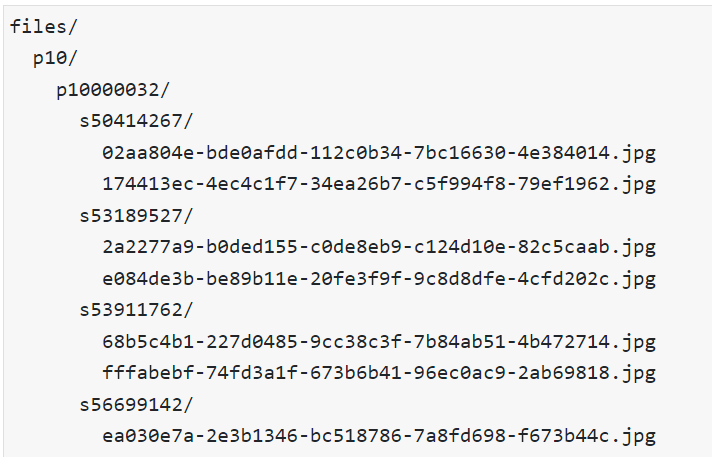

#### Number of unique subject_id in the Patient table : 

In [ ]:
print(len(df_patients["subject_id"].unique()))

#### Number of unique subject_id in the mimic_cxr_chexpert table : 

In [ ]:
print(len(df_mimic_cxr_chexpert["subject_id"].unique()))


#### Number of unique dicom_id and subject_id in the mimic_cxr_metadata table : 

In [ ]:
print(len(df_mimic_cxr_metadata["dicom_id"].unique()))
print(len(df_mimic_cxr_metadata["subject_id"].unique()))

print(len(df_mimic_cxr_metadata["subject_id"].unique()))

#### Number of unique subject_id, hadm_id, stay_id in the Icustays table : 

In [ ]:
print(len(df_icustays["subject_id"].unique()))
print(len(df_icustays["hadm_id"].unique()))
print(len(df_icustays["stay_id"].unique()))


## 2-Filter out patient with icu stays and cxr data

the goal is to find the patients that have both icu and cxr data.

We start by reading the following data sources:

- mimic_cxr_chexpert : the file containing all patients with a chest pathology measurements, meaning those who have a chest radiology image



- icustays : the file containing all patients with an icu stay, meaning those who have a stay_id in the icustays table


Then, we find the intersection between the two datasets.

#### Read data from local source

In [ ]:
df_mimic_cxr_chexpert = read_csv(constants.mimic_cxr_chexpert)
df_icustays = read_csv(constants.icustays)

In [ ]:
print('The number of patients with a chest radiology image is:')

print(len(df_mimic_cxr_chexpert["subject_id"].unique()))

print('The number of patients with an icu stay is:')

print(len(df_icustays["subject_id"].unique()))

### Find the intersection between the two datasets:

In [ ]:
icu_cxr_patients = pd.Series(list(set(df_mimic_cxr_chexpert["subject_id"]).intersection(set(df_icustays["subject_id"]))))


In [ ]:
print('The number of patients with both a chest radiology image and an icu stay is:')

len(icu_cxr_patients)

### Saving the result to a csv file

In [ ]:
icu_cxr_patients.to_csv("csvs/icu_cxr_patients.csv")

### Selecting a cohort of 10 patients and saving the result to a csv file

This cohort can be used for the tests and features generation

In [ ]:
icu_cxr_patients_sample10 = icu_cxr_patients.sample(10, random_state=0)

Note : use the list of patients in the constants data file to have the same 

### Saving the result to a csv file

In [ ]:
icu_cxr_patients_sample10.to_csv("csvs/icu_cxr_patients_sample10.csv")